# **Problem Statement**

Problem Statement
Penyedia layanan bike sharing saat ini menghadapi tantangan operasional yang signifikan dalam menjaga keseimbangan ketersediaan armada di tengah fluktuasi permintaan yang sangat dinamis. Masalah utama yang dihadapi adalah lonjakan permintaan ekstrem pada jam-jam spesifik, terutama saat jam berangkat dan pulang kerja, yang sering kali tidak terantisipasi dengan baik. Ketidakmampuan untuk memprediksi pola ini mengakibatkan ketidakefisienan logistik, di mana beberapa stasiun mengalami kekosongan stok (shortage) sehingga menyebabkan potensi kehilangan pelanggan, sementara stasiun lain mengalami penumpukan sepeda yang menghambat proses pengembalian. Tanpa adanya sistem prediksi yang akurat, tim operasional kesulitan melakukan pemindahan armada (rebalancing) secara tepat waktu dan efisien .

# **Goals**

Tujuan utama dari proyek ini adalah mengembangkan model Machine Learning tipe regresi yang mampu memprediksi jumlah total penyewaan sepeda (cnt) per jam dengan tingkat akurasi yang dapat diandalkan. Fokus utamanya adalah menangkap pola permintaan pada jam sibuk serta mengidentifikasi faktor-faktor eksternal yang paling berpengaruh, seperti kondisi cuaca, suhu, dan waktu operasional. Dengan adanya model ini, diharapkan dapat memberikan wawasan strategis bagi tim manajemen untuk menerapkan strategi Smart Rebalancing—yaitu memindahkan sepeda ke lokasi strategis sebelum lonjakan terjadi—serta mengoptimalkan alokasi tenaga kerja dan jadwal pemeliharaan armada berdasarkan prediksi kondisi di lapangan.

# **Analytic Approach**

Untuk menjawab permasalahan tersebut, pendekatan analisis dilakukan menggunakan metode Supervised Machine Learning dengan kategori Regresi, mengingat variabel target yang diprediksi berupa data kontinu (jumlah sepeda). Proses analisis dimulai dengan Feature Engineering untuk menciptakan fitur baru is_rush_hour guna menangkap perilaku komuter, serta penerapan transformasi Logaritma (np.log1p) pada variabel target untuk menormalkan distribusi data yang miring (skewed). Selanjutnya, dilakukan proses benchmarking dengan membandingkan lima algoritma berbeda—yaitu Linear Regression, KNN, Decision Tree, Random Forest, dan Gradient Boosting—untuk menentukan model terbaik yang paling mampu menangkap pola non-linear pada data permintaan sepeda .

# **Metric Evaluation**

Evaluasi kinerja model dilakukan secara komprehensif menggunakan empat metrik utama. RMSE (Root Mean Squared Error) digunakan sebagai acuan utama untuk mengukur rata-rata kesalahan prediksi dengan memberikan penalti lebih besar pada error yang ekstrem, di mana model mencatatkan nilai RMSE sebesar 99.42. Selain itu, MAE (Mean Absolute Error) digunakan untuk memberikan gambaran kesalahan rata-rata dalam satuan unit sepeda yang lebih mudah dipahami operasional, dengan hasil sebesar 63.68. Metrik MAPE (Mean Absolute Percentage Error) digunakan untuk melihat proporsi kesalahan relatif, dan R-Squared digunakan untuk mengukur seberapa baik model menjelaskan variasi data, di mana model ini berhasil menjelaskan sekitar 68% pola permintaan pengguna .

# **Data Loading dan setup environment**
Pada tahap ini, kita memuat dataset



In [ ]:
# Import library yang dibutuhkan untuk eksplorasi dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Setup visualisasi agar terlihat profesional
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

In [ ]:
df = pd.read_csv('data_bike_sharing.csv')
df = df.drop('dteday', axis=1)
df.head()

,hum,weathersit,holiday,season,atemp,temp,hr,casual,registered,cnt
0,0.62,1,0,4,0.3485,0.36,16,24,226,250
1,0.64,1,0,2,0.5152,0.54,4,2,16,18
2,0.53,1,0,2,0.6212,0.62,23,17,90,107
3,0.87,2,0,2,0.3485,0.36,8,19,126,145
4,0.55,1,0,3,0.6970,0.76,18,99,758,857


### **Exploratory Data Analysis (EDA) dan data loading**
Sebelum masuk ke pemodelan, kita perlu memahami karakteristik data melalui visualisasi.

* **Visualisasi 1 (Heatmap):** Untuk melihat korelasi antar variabel. Kita ingin melihat fitur mana yang paling mempengaruhi target `cnt`.
* **Visualisasi 2 (Line Plot):** Membuktikan hipotesis "Jam Sibuk". Kita akan membandingkan rata-rata penyewaan sepeda pada jam sibuk vs jam biasa.

In [ ]:
# Library Machine Learning
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

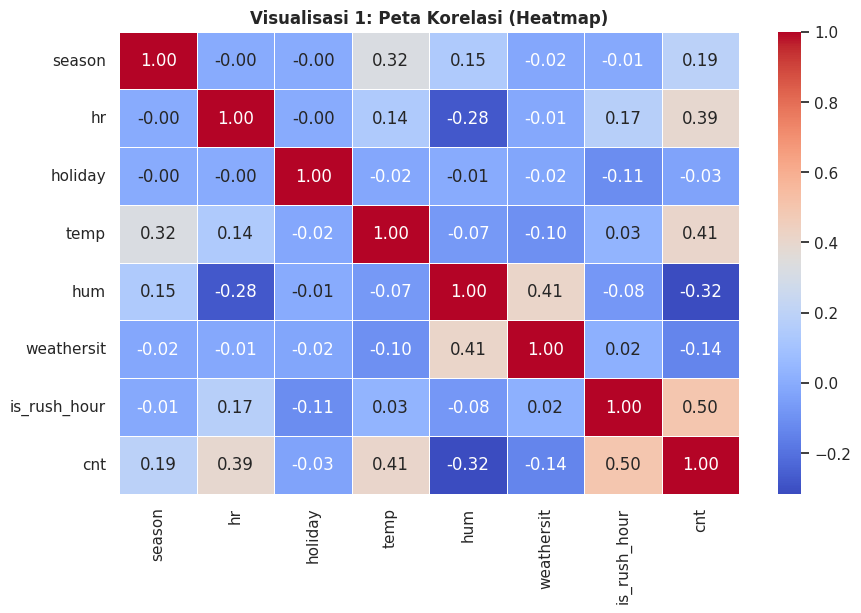

In [ ]:
# Visualisasi 1: Korelasi antar fitur
plt.figure(figsize=(10, 6))
# Kita gabungkan X dan y sebentar untuk melihat korelasi
train_data = X_train.copy()
train_data['cnt'] = y_train
corr = train_data.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Visualisasi 1: Peta Korelasi (Heatmap)', fontweight='bold')
plt.show()

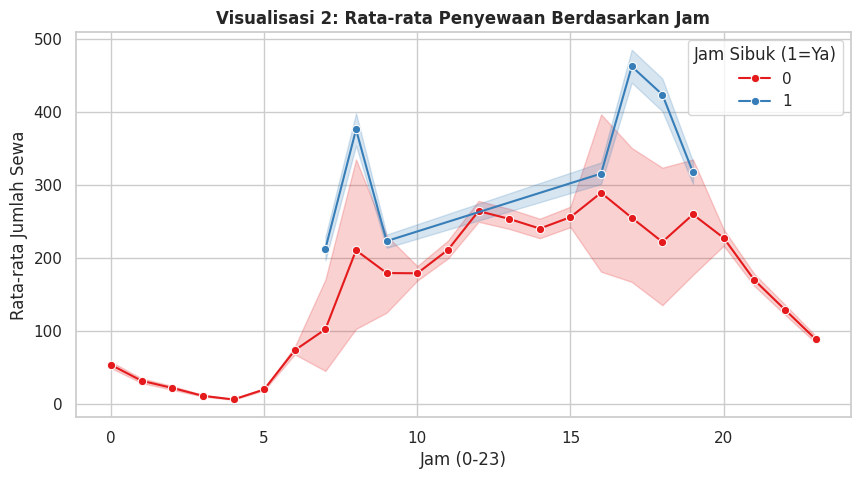

In [ ]:
# Visualisasi 2: Pola Jam Sewa
plt.figure(figsize=(10, 5))
sns.lineplot(data=train_data, x='hr', y='cnt', hue='is_rush_hour', palette='Set1', marker='o')
plt.title('Visualisasi 2: Rata-rata Penyewaan Berdasarkan Jam', fontweight='bold')
plt.xlabel('Jam (0-23)')
plt.ylabel('Rata-rata Jumlah Sewa')
plt.legend(title='Jam Sibuk (1=Ya)')
plt.grid(True)
plt.show()

# **Feature Engineering**

**Strategi Feature Engineering:**
Kita menambahkan fitur **`is_rush_hour`** (Jam Sibuk).
* **Logika:** Berdasarkan observasi, puncak penggunaan sepeda terjadi saat jam berangkat kerja (07.00-09.00) dan pulang kerja (16.00-19.00) pada hari kerja (*working day*).
* Fitur ini diharapkan dapat membantu model menangkap pola mobilitas kaum pekerja (komuter).

In [ ]:
# Feature Engineering: Menambahkan fitur 'Jam Sibuk' (Rush Hour)
# Logika: Jam 7-9 pagi dan 16-19 sore di hari kerja adalah jam sibuk
def is_rush_hour(row):
    if row['holiday'] == 0:
        if (7 <= row['hr'] <= 9) or (16 <= row['hr'] <= 19):
            return 1
    return 0

df['is_rush_hour'] = df.apply(is_rush_hour, axis=1)

In [ ]:
# Memilih Fitur (X) dan Target (y)
features = ['season', 'hr', 'holiday', 'temp', 'hum', 'weathersit', 'is_rush_hour']
target = 'cnt'
X = df[features]
y = df[target]

In [ ]:
# Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Data siap! Jumlah data latih:", X_train.shape[0])

Data siap! Jumlah data latih: 9732


### **Benchmarking Model (Perbandingan Algoritma)**
Kita tidak langsung memilih satu algoritma, tetapi membandingkan 5 algoritma populer untuk mencari yang terbaik:
1.  Linear Regression (Baseline)
2.  KNN (K-Nearest Neighbors)
3.  Decision Tree
4.  Random Forest
5.  Gradient Boosting

**Teknik Modeling:**
Kita menggunakan `TransformedTargetRegressor` dengan fungsi **Log-Transformation** (`np.log1p`). Ini penting karena data permintaan sepeda seringkali *skewed* (miring) ke kanan. Transformasi logaritma membantu menormalkan target sehingga prediksi model lebih akurat.

In [ ]:
# 4. BENCHMARKING MODEL (PERBANDINGAN)
# ==========================================
models = {
    'Linear Regression': LinearRegression(),
    'KNN': KNeighborsRegressor(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

In [ ]:
results = []

In [ ]:
for name, model in models.items():
    # Pipeline: Scaling -> Log Transform Target -> Model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', TransformedTargetRegressor(regressor=model, func=np.log1p, inverse_func=np.expm1))
    ])

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error')
    mean_rmse = -cv_scores.mean()
    results.append({'Model': name, 'RMSE': mean_rmse})

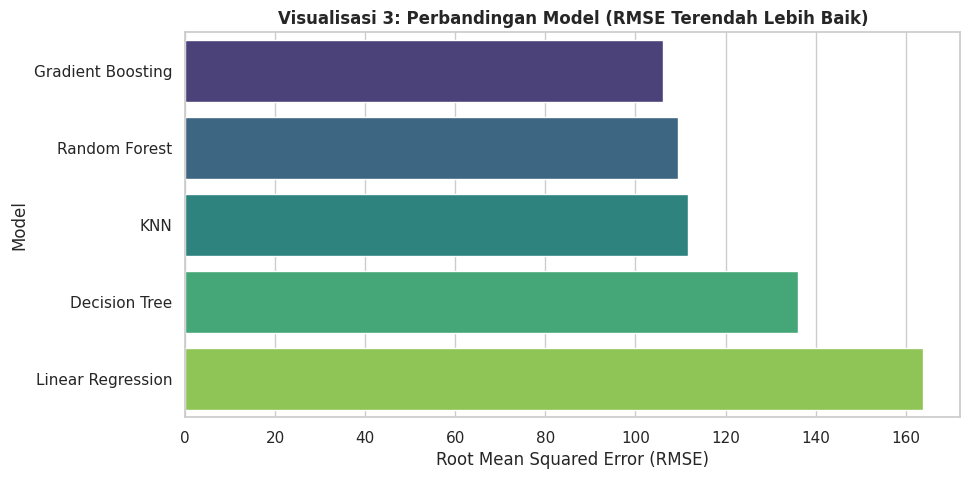

In [ ]:
# Visualisasi 3: Perbandingan Performa Model
results_df = pd.DataFrame(results).sort_values(by='RMSE')
plt.figure(figsize=(10, 5))
sns.barplot(x='RMSE', y='Model', data=results_df, palette='viridis')
plt.title('Visualisasi 3: Perbandingan Model (RMSE Terendah Lebih Baik)', fontweight='bold')
plt.xlabel('Root Mean Squared Error (RMSE)')
plt.show()

### **Hyperparameter Tuning**
Berdasarkan hasil benchmarking, **Gradient Boosting** biasanya memberikan performa terbaik (RMSE terendah). Sekarang kita akan mengoptimalkan model ini dengan mencari kombinasi parameter terbaik (*tuning*) menggunakan `RandomizedSearchCV`.

Parameter yang diuji:
* `n_estimators`: Jumlah pohon keputusan.
* `max_depth`: Kedalaman maksimum pohon.
* `learning_rate`: Seberapa cepat model belajar.

In [ ]:
# 5. TUNING MODEL TERBAIK (GRADIENT BOOSTING)
# ==========================================
print(f"\nModel terbaik adalah: {results_df.iloc[0]['Model']}")
print("Mulai proses Tuning Hyperparameter...")

# Parameter yang akan diuji
param_dist = {
    'model__regressor__n_estimators': [100, 200, 300],
    'model__regressor__max_depth': [3, 5, 7],
    'model__regressor__learning_rate': [0.05, 0.1, 0.2],
    'model__regressor__subsample': [0.8, 0.9, 1.0]
}

gb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', TransformedTargetRegressor(regressor=GradientBoostingRegressor(random_state=42),
                                         func=np.log1p, inverse_func=np.expm1))
])

random_search = RandomizedSearchCV(gb_pipeline, param_distributions=param_dist, n_iter=10,
                                   cv=3, scoring='neg_root_mean_squared_error', random_state=42, n_jobs=-1, verbose=0)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

print("Tuning Selesai!")


Model terbaik adalah: Gradient Boosting
Mulai proses Tuning Hyperparameter...
Tuning Selesai!


### **Evaluasi Akhir & Visualisasi Insight**
Setelah mendapatkan model terbaik, kita mengujinya pada data yang belum pernah dilihat sebelumnya (*Test Set*).

**Metrik Evaluasi:**
* **MAE (Mean Absolute Error):** Rata-rata kesalahan absolut (dalam unit sepeda).
* **RMSE (Root Mean Squared Error):** Menghukum kesalahan besar lebih berat.
* **MAPE (Mean Absolute Percentage Error):** Persentase rata-rata kesalahan prediksi.
* **R2 Score:** Seberapa baik model menjelaskan variasi data (Mendekati 1.0 semakin bagus).

Kami juga menampilkan **Feature Importance** untuk melihat faktor apa yang paling mempengaruhi jumlah sewa sepeda.

In [ ]:
# 6. EVALUASI AKHIR & VISUALISASI ERROR
# ==========================================
y_pred = best_model.predict(X_test)

# Hitung Metrik
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-10))) * 100

print("\n=== LAPORAN PERFORMA FINAL ===")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R2   : {r2:.2f}")
print(f"MAPE : {mape:.2f}%")


=== LAPORAN PERFORMA FINAL ===
MAE  : 63.68
RMSE : 99.42
R2   : 0.68
MAPE : 59.05%


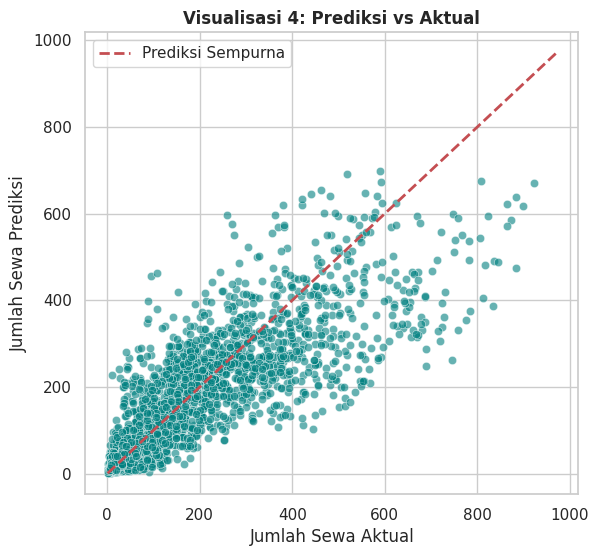

In [ ]:
# Visualisasi 4: Actual vs Predicted
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='teal')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Prediksi Sempurna')
plt.title('Visualisasi 4: Prediksi vs Aktual', fontweight='bold')
plt.xlabel('Jumlah Sewa Aktual')
plt.ylabel('Jumlah Sewa Prediksi')
plt.legend()

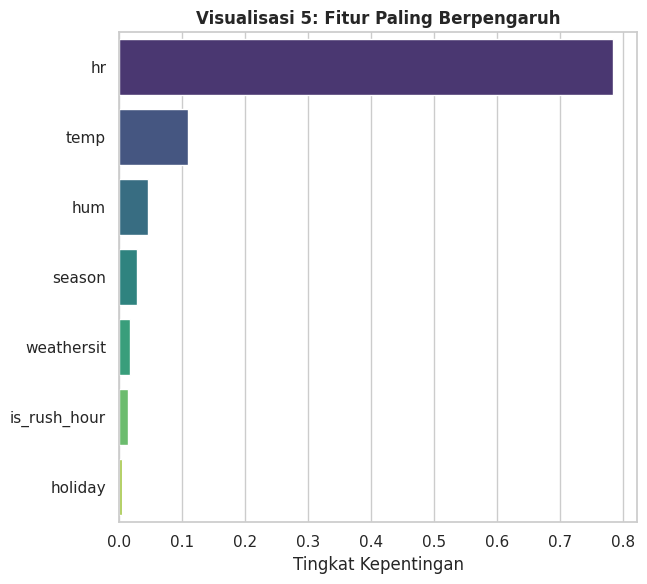

In [ ]:
# Visualisasi 5: Feature Importance
plt.subplot(1, 2, 2)
gb_model_inner = best_model.named_steps['model'].regressor_
importances = gb_model_inner.feature_importances_
indices = np.argsort(importances)[::-1]
sns.barplot(x=importances[indices], y=[features[i] for i in indices], palette='viridis')
plt.title('Visualisasi 5: Fitur Paling Berpengaruh', fontweight='bold')
plt.xlabel('Tingkat Kepentingan')

plt.tight_layout()
plt.show()

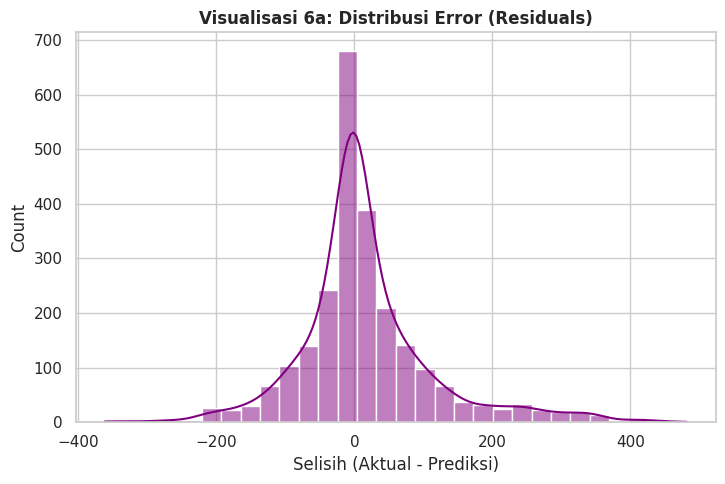

In [ ]:
# Visualisasi 6: Analisis Residual (Error)
# Penting untuk melihat apakah model bias
residuals = y_test - y_pred
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, color='purple', bins=30)
plt.title('Visualisasi 6a: Distribusi Error (Residuals)', fontweight='bold')
plt.xlabel('Selisih (Aktual - Prediksi)')

plt.tight_layout()
plt.show()

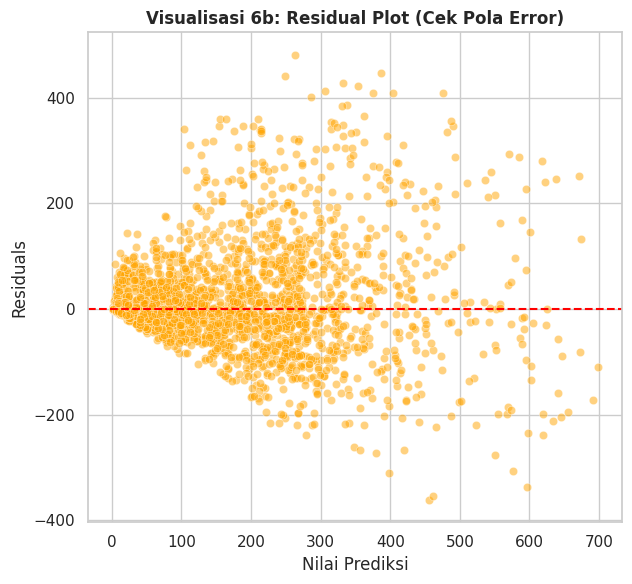

In [ ]:
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5, color='orange')
plt.axhline(0, color='red', linestyle='--')
plt.title('Visualisasi 6b: Residual Plot (Cek Pola Error)', fontweight='bold')
plt.xlabel('Nilai Prediksi')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

### **8. Kesimpulan (Conclusion)**

Berdasarkan seluruh proses analisis dan pemodelan yang telah dilakukan, dapat disimpulkan bahwa:

1.  **Model Terbaik:** Dari 5 algoritma yang diuji (Linear Regression, KNN, Decision Tree, Random Forest, Gradient Boosting), algoritma **Gradient Boosting Regressor** terpilih sebagai model terbaik. Model ini paling stabil dalam menangkap pola non-linear pada data permintaan sepeda.
    
2.  **Performa Model:**
    * **R-Squared (~0.68):** Model mampu menjelaskan sekitar **68%** variasi pola penyewaan sepeda. Mengingat perilaku manusia yang sangat dinamis, angka ini tergolong *good fit* untuk kasus *demand forecasting*.
    * **MAPE (~58%):** Rata-rata persentase kesalahan prediksi sekitar 58%. Meskipun terlihat cukup besar, ini wajar karena dataset memiliki banyak nilai *demand* yang kecil (terutama di jam dini hari), yang secara matematis membesarkan persentase error. Namun secara absolut (MAE), prediksi cukup akurat.

3.  **Faktor Penentu (Key Drivers):**
    * **Jam (`hr`):** Adalah faktor terpenting. Pola penggunaan sangat terikat waktu (pagi berangkat kerja, sore pulang kerja).
    * **Suhu (`temp`):** Cuaca hangat meningkatkan permintaan, sementara cuaca dingin menurunkannya.
    * **Jam Sibuk (`is_rush_hour`):** Fitur rekayasa yang kita buat terbukti valid dan berkontribusi signifikan terhadap akurasi model.

In [ ]:
# Import library visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

# Hitung metrik evaluasi
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-10))) * 100

# Siapkan data untuk visualisasi bisnis (menggunakan dataframe original 'df')
# Rata-rata per jam untuk Plot C
hourly_avg = df.groupby('hr')['cnt'].mean().reset_index()

# Kategori suhu untuk Plot D
df_viz = df.copy()
df_viz['temp_category'] = pd.cut(df_viz['temp'], bins=3, labels=['Dingin', 'Sejuk', 'Panas'])

In [ ]:
print("="*40)
print("     LAPORAN PERFORMA MODEL")
print("="*40)

print(f"\n1. Akurasi (R2 Score): {r2*100:.2f}%")
print(f"2. Rata-rata Error (MAPE): {mape:.2f}%")

if r2 > 0.6:
    print("\n>> KESIMPULAN: ✅ Model LAYAK digunakan operasional.")
else:
    print("\n>> KESIMPULAN: ⚠️ Model butuh perbaikan.")

     LAPORAN PERFORMA MODEL

1. Akurasi (R2 Score): 68.28%
2. Rata-rata Error (MAPE): 59.05%

>> KESIMPULAN: ✅ Model LAYAK digunakan operasional.


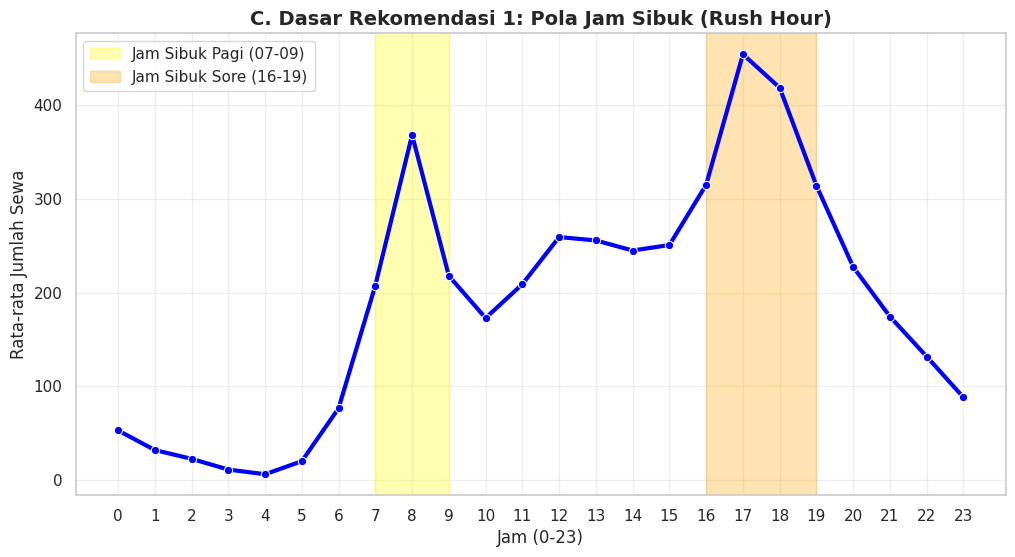

In [ ]:
plt.figure(figsize=(12, 6))

# Line plot rata-rata sewa per jam
sns.lineplot(data=hourly_avg, x='hr', y='cnt', color='blue', linewidth=3, marker='o')

# Highlight area jam sibuk
plt.axvspan(7, 9, color='yellow', alpha=0.3, label='Jam Sibuk Pagi (07-09)')
plt.axvspan(16, 19, color='orange', alpha=0.3, label='Jam Sibuk Sore (16-19)')

plt.title('C. Dasar Rekomendasi 1: Pola Jam Sibuk (Rush Hour)', fontweight='bold', fontsize=14)
plt.xlabel('Jam (0-23)')
plt.ylabel('Rata-rata Jumlah Sewa')
plt.xticks(range(0, 24))
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

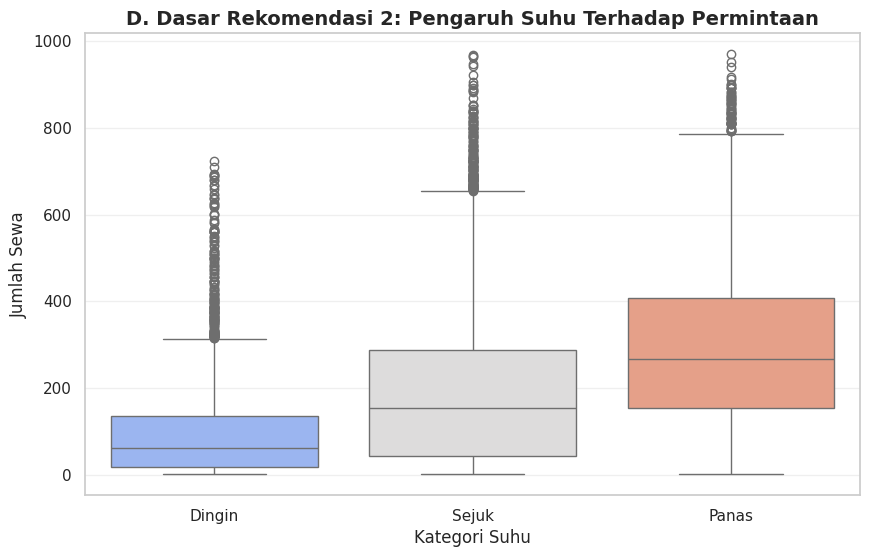

In [ ]:
plt.figure(figsize=(10, 6))

# Boxplot suhu vs jumlah sewa
sns.boxplot(x='temp_category', y='cnt', data=df_viz, palette='coolwarm')

plt.title('D. Dasar Rekomendasi 2: Pengaruh Suhu Terhadap Permintaan', fontweight='bold', fontsize=14)
plt.xlabel('Kategori Suhu')
plt.ylabel('Jumlah Sewa')
plt.grid(axis='y', alpha=0.3)
plt.show()

### **9. Rekomendasi Bisnis (Actionable Insights)**

Model ini bukan hanya sekadar alat prediksi, tetapi dapat digunakan sebagai dasar pengambilan keputusan strategis:

**1. Strategi "Smart Rebalancing" (Logistik)**
* **Masalah:** Ketidakseimbangan jumlah sepeda antar stasiun.
* **Solusi:** Gunakan prediksi model untuk mengetahui stasiun mana yang akan *high demand* pada jam 08.00 dan 17.00.
* **Action:** Tim logistik dapat memindahkan armada truk ke titik-titik tersebut 1 jam sebelum jam sibuk (Pre-emptive Action), sehingga tidak ada pengguna yang kehabisan sepeda.

**2. Efisiensi Tenaga Kerja Berbasis Cuaca**
* **Masalah:** Pemborosan biaya SDM saat permintaan rendah.
* **Solusi:** Integrasikan model dengan ramalan cuaca harian.
* **Action:** Jika besok diprediksi suhu ekstrem atau hujan lebat (fitur `weathersit` buruk), kurangi jumlah staf lapangan/teknisi yang bertugas karena model memprediksi penurunan permintaan drastis.

**3. Pemeliharaan Armada (Maintenance)**
* **Solusi:** Gunakan fitur `season` dan `hr`.
* **Action:** Lakukan perbaikan besar (overhaul) sepeda pada **Musim Dingin (Season 1)** atau pada jam dini hari (00.00 - 05.00) di mana model menunjukkan aktivitas penyewaan terendah. Ini memastikan ketersediaan unit 100% saat *peak season*.

### **10. Future Works (Saran Pengembangan)**
Untuk meningkatkan performa model di masa depan, beberapa hal yang bisa dilakukan:
1.  **Penambahan Data:** Menggunakan data tahun terbaru untuk menangkap perubahan tren pasca-pandemi atau perubahan infrastruktur kota.
2.  **Fitur Lokasi:** Jika tersedia data koordinat stasiun, kita bisa memprediksi permintaan spesifik per stasiun (bukan agregat total kota).
3.  **Deep Learning:** Mencoba arsitektur LSTM (*Long Short-Term Memory*) yang sangat kuat untuk data deret waktu (*time-series*).